In [ ]:
# Cell: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot settings
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style("whitegrid")

# Cell: load data (ensure data/benin_clean.csv etc. exist locally and are in .gitignore)
data_dir = "data"

paths = {
    "Benin": os.path.join(data_dir, "benin_eda_clean.csv"),
    "Togo": os.path.join(data_dir, "togo_clean.csv"),
    "Sierra Leone": os.path.join(data_dir, "sierra_leone_clean.csv")
}

dfs = {}
for country, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"{p} not found. Place cleaned CSV at this path.")
    dfs[country] = pd.read_csv(p, parse_dates=True, infer_datetime_format=True)
    # optionally parse timestamp if present
    if 'Timestamp' in dfs[country].columns:
        dfs[country]['Timestamp'] = pd.to_datetime(dfs[country]['Timestamp'], errors='coerce')

# Quick preview
for c, df in dfs.items():
    print(f"{c}: {df.shape}")
    display(df.head(2))


C:\Users\PC\AppData\Local\Temp\ipykernel_26796\4096397526.py:25: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[country] = pd.read_csv(p, parse_dates=True, infer_datetime_format=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_26796\4096397526.py:25: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[country] = pd.read_csv(p, parse_dates=True, infer_datetime_format=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_26796\4096397526.py:25: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict ver

Benin: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN


Togo: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN


Sierra Leone: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-30 00:01:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
1,2021-10-30 00:02:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN


Harmonize column names & create combined frame

In [9]:
# Cell: harmonize columns (adjust names if your cleaned CSV uses different headers)
metrics = ["GHI", "DNI", "DHI"]  # required metrics

# Check metrics existence
for c, df in dfs.items():
    missing = [m for m in metrics if m not in df.columns]
    if missing:
        print(f"Warning: {c} is missing columns: {missing}")

# Create combined dataframe with country label
combined = []
for country, df in dfs.items():
    tmp = df.copy()
    tmp['country'] = country
    combined.append(tmp[[*metrics, 'country']])
combined = pd.concat(combined, ignore_index=True)
combined = combined.dropna(subset=['country'])  # safety
combined.shape


(1576800, 4)

 Summary table: mean, median, std (per country & metric)

In [10]:
# Cell: summary statistics table
agg_funcs = ['mean', 'median', 'std']
summary = combined.groupby('country')[metrics].agg(agg_funcs)
# Flatten multiindex columns
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()

# Nicely display
summary_round = summary.copy()
for col in summary_round.columns:
    if col != 'country':
        summary_round[col] = summary_round[col].round(3)
display(summary_round)

# Save summary table locally (optional)
summary_round.to_csv('comparison_summary_table.csv', index=False)


,country,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
0,Benin,240.559,1.8,331.131,167.188,-0.1,261.711,115.359,1.6,158.691
1,Sierra Leone,201.958,0.3,298.495,116.376,-0.1,218.653,113.721,-0.1,158.946
2,Togo,230.555,2.1,322.532,151.258,0.0,250.957,116.444,2.5,156.521


Boxplots (one plot per metric, colored by country)

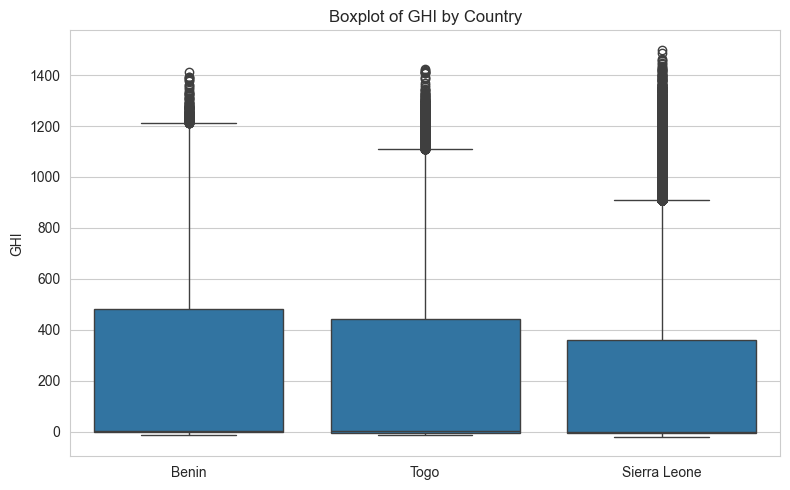

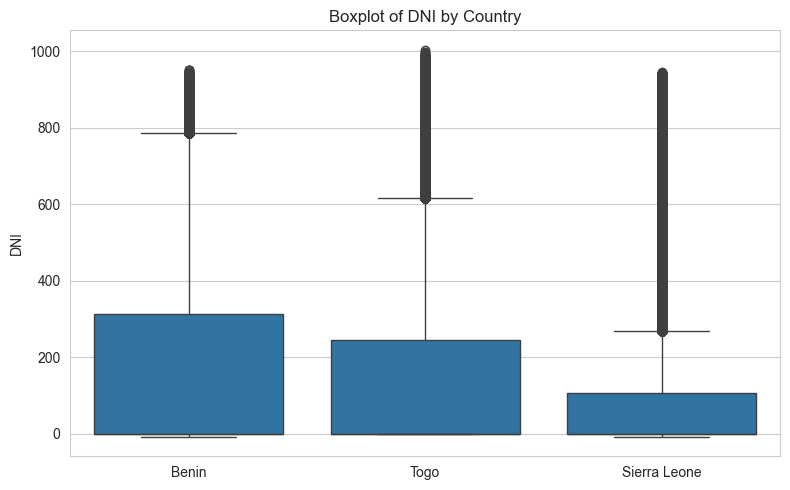

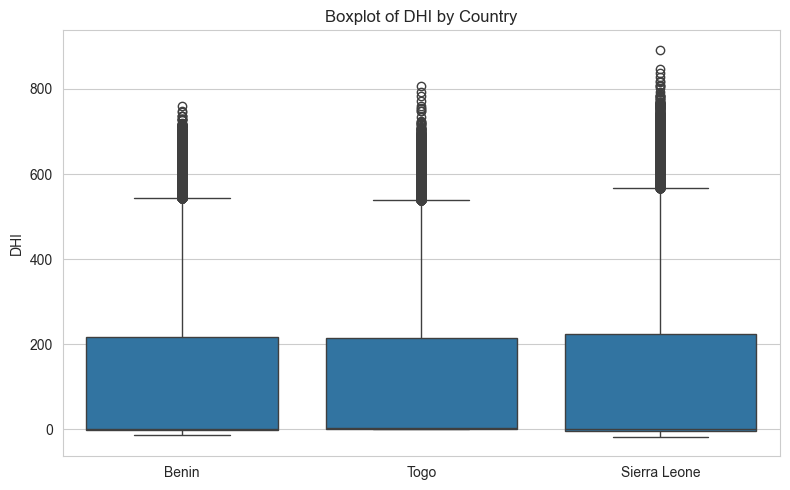

In [11]:
# Cell: boxplots
for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='country', y=metric, data=combined)
    plt.title(f"Boxplot of {metric} by Country")
    plt.xlabel("")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


Statistical Testing: One-way ANOVA and Kruskal–Wallis (nonparametric)

In [13]:
from spicy import stats

# Cell: prepare grouped arrays
grouped = {country: combined[combined['country']==country]['GHI'].dropna().values for country in combined['country'].unique()}

# 1) Check normality roughly with Shapiro per group (note: Shapiro is sensitive to sample size)
normality = {}
for country, arr in grouped.items():
    if len(arr) < 3:
        normality[country] = {'n': len(arr), 'shapiro_p': np.nan}
    else:
        sh_p = stats.shapiro(arr[:5000]).pvalue if len(arr) > 3 else np.nan  # limit for speed
        normality[country] = {'n': len(arr), 'shapiro_p': sh_p}
display(pd.DataFrame.from_dict(normality, orient='index'))

# 2) Levene test for equal variances
levene_stat, levene_p = stats.levene(*[v for v in grouped.values() if len(v)>0])
print(f"Levene test p-value: {levene_p:.5f}")

# 3) One-way ANOVA (if assumptions roughly ok)
anova_stat, anova_p = stats.f_oneway(*[v for v in grouped.values() if len(v)>0])
print(f"One-way ANOVA F={anova_stat:.4f}, p={anova_p:.5e}")

# 4) Kruskal–Wallis (nonparametric alternative)
kruskal_stat, kruskal_p = stats.kruskal(*[v for v in grouped.values() if len(v)>0])
print(f"Kruskal-Wallis H={kruskal_stat:.4f}, p={kruskal_p:.5e}")

# Summarize p-values in a dataframe
tests = pd.DataFrame({
    'test': ['levene', 'anova', 'kruskal'],
    'statistic': [levene_stat, anova_stat, kruskal_stat],
    'p_value': [levene_p, anova_p, kruskal_p]
})
display(tests)


ModuleNotFoundError: No module named 'spicy'